# Exploratory Analysis
---
This notebook downloads the two primary datasets used for training the model, one containing ham and spam emails, and the other containing phishing emails.

1. Imports
2. Downloading the data.
3. Data Inspection.
4. Cleaning the data.
5. Saving cleaned data to a csv file.

## 1. Imports

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
from pathlib import Path
import csv
import re
import json

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

## 2. Downloading the Data

Download the datasets using `kagglehub`, and are stored in `/home/<user>//.cache/kagglehub/datasets/...` (Unix/Linux path). Path may be different if installed on Windows system.

1. https://www.kaggle.com/datasets/marcelwiechmann/enron-spam-data
2. https://www.kaggle.com/datasets/subhajournal/phishingemails

In [38]:
# Get the path to the Phishing_Email.csv file using the current user's cache directory
path = f"{os.path.expanduser('~')}/.cache/kagglehub/datasets/marcelwiechmann/enron-spam-data/versions/3"

if not Path(path).exists():
    # If the file doesn't exist, download it
    path = kagglehub.dataset_download("marcelwiechmann/enron-spam-data")

hamSpam_df = pd.read_csv(f"{path}/enron_spam_data.csv")
hamSpam_df.to_csv("data/hamSpam.csv")
hamSpam_df.head(5)

,Unnamed: 0,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [39]:
# Get the path to the Phishing_Email.csv file using the current user's cache directory
path = f"{os.path.expanduser('~')}/.cache/kagglehub/datasets/subhajournal/phishingemails/versions/1"

if not Path(path).exists():
    # If the file doesn't exist, download it
    path = kagglehub.dataset_download("subhajournal/phishingemails")

phish_df = pd.read_csv(f"{path}/Phishing_Email.csv")
phish_df.to_csv("data/phish.csv")
phish_df.head(5)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [40]:
list(hamSpam_df.columns.values) , list(phish_df.columns.values)

(['Unnamed: 0', 'Subject', 'Message', 'Spam/Ham', 'Date'],
 ['Unnamed: 0', 'Email Text', 'Email Type'])

In [41]:
hamSpam_df.count()

Unnamed: 0    33716
Subject       33716
Message       33664
Spam/Ham      33716
Date          33716
dtype: int64

In [42]:
phish_df.count()

Unnamed: 0    18650
Email Text    18634
Email Type    18650
dtype: int64

In [43]:
# Rename known columns (no error if source names are missing)
hamSpam_df = hamSpam_df.rename(columns={"Spam/Ham": "Email Type", "Message": "Email Text"})

# Drop optional columns only if they exist to avoid KeyError
cols_to_drop = [c for c in ["Date", "Subject"] if c in hamSpam_df.columns]
if cols_to_drop:
	hamSpam_df = hamSpam_df.drop(columns=cols_to_drop)

In [44]:
hamSpam_df = hamSpam_df[hamSpam_df['Email Type'].isin(['ham', 'spam'])]

In [45]:
hamSpam_df.to_csv(
    "data/hamSpam_fixed.csv",
    index=False,
    quoting=csv.QUOTE_ALL,
    escapechar="\\"
)

In [46]:
phish_df['Email Type'].apply(repr).unique()


array(["'Safe Email'", "'Phishing Email'"], dtype=object)

In [47]:
phish_df['Email Type'] = phish_df['Email Type'].replace({'Safe Email': 'ham', 'Phishing Email': 'phish'})
phish_df['Email Type'].apply(repr).unique()

array(["'ham'", "'phish'"], dtype=object)

In [48]:
emailDataset = pd.concat([hamSpam_df, phish_df], ignore_index=True)
emailDataset['Email Type'].apply(repr).unique()

array(["'ham'", "'spam'", "'phish'"], dtype=object)

In [49]:
emailDataset.count()

Unnamed: 0    52366
Email Text    52298
Email Type    52366
dtype: int64

## Clean Rows
Drop rows that either have an NA or "empty" value.

In [50]:
emailDataset.dropna(inplace=True)
empty_rows = emailDataset[emailDataset["Email Text"] == "empty"]
emailDataset.drop(empty_rows.index, inplace=True)
emailDataset

,Unnamed: 0,Email Text,Email Type
1,1,"gary , production from the high island larger ...",ham
2,2,- calpine daily gas nomination 1 . doc,ham
3,3,fyi - see note below - already done .\nstella\...,ham
4,4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham
5,5,"jackie ,\nsince the inlet to 3 river plant is ...",ham
...,...,...,...
52360,18645,\nRick Moen a Ã©crit:> > I'm confused. I thou...,ham
52361,18646,date a lonely housewife always wanted to date ...,phish
52362,18647,request submitted : access request for anita ....,ham
52363,18648,"re : important - prc mtg hi dorn & john , as y...",ham


## Statistics
Get ham, spam, and phish row count after cleanup.

In [52]:
summary_df = emailDataset.copy()

In [53]:
summary_df["Email Type"].value_counts()

Email Type
ham      27617
spam     17171
phish     6977
Name: count, dtype: int64

Most data is legitimate (ham), so the model may overfit to it. Sampling balance may be needed.

In [ ]:
# Text length metrics
summary_df["char_count"] = summary_df["Email Text"].str.len()
summary_df["word_count"] = summary_df["Email Text"].apply(lambda x: len(x.split()))

# Count URLs
url_pattern = r"http[s]?://\S+|www\.\S+"
summary_df["url_count"] = summary_df["Email Text"].apply(lambda x: len(re.findall(url_pattern, x)))

# Count special characters
summary_df["special_chars"] = summary_df["Email Text"].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

# Count uppercase words
summary_df["uppercase_words"] = summary_df["Email Text"].apply(lambda x: len([w for w in x.split() if w.isupper()]))


In [58]:

summary_df[["char_count", "word_count"]].describe()

,char_count,word_count
count,5.176500e+04,5.176500e+04
mean,2.052634e+03,4.254914e+02
std,7.499507e+04,1.552447e+04
min,1.000000e+00,0.000000e+00
25%,5.760000e+02,1.150000e+02
50%,8.820000e+02,1.740000e+02
75%,1.674000e+03,3.550000e+02
max,1.703669e+07,3.527576e+06


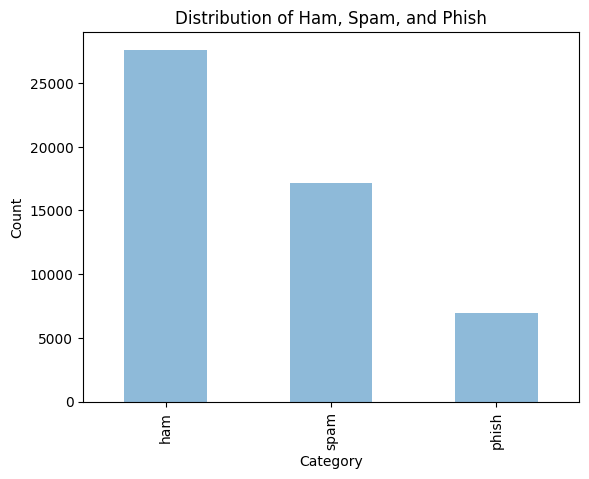

In [88]:
summary_df["Email Type"].value_counts().plot(kind='bar', alpha=0.5)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Ham, Spam, and Phish')
plt.show()

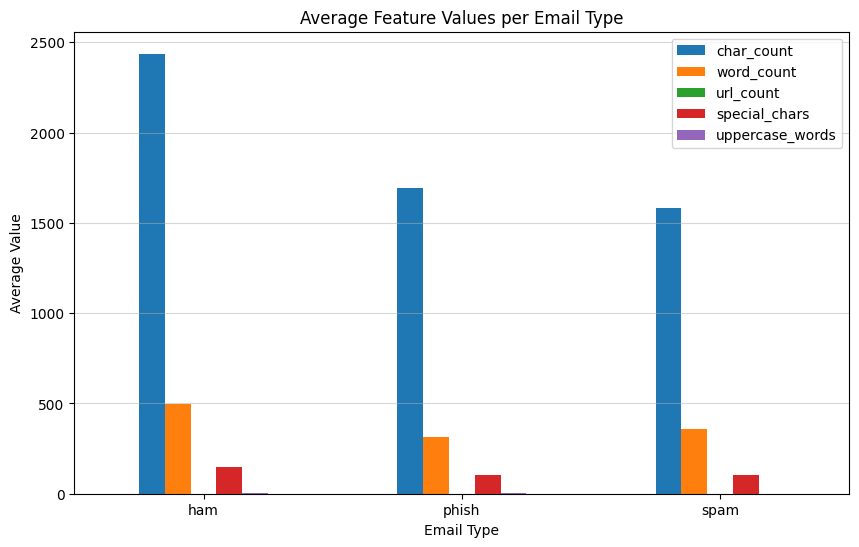

In [86]:
feature_cols = ["char_count", "word_count", "url_count", "special_chars", "uppercase_words"]
grouped = summary_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6))
plt.title("Average Feature Values per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

In [71]:
# Ensure NLTK downloads (run once)
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/prokope/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/prokope/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

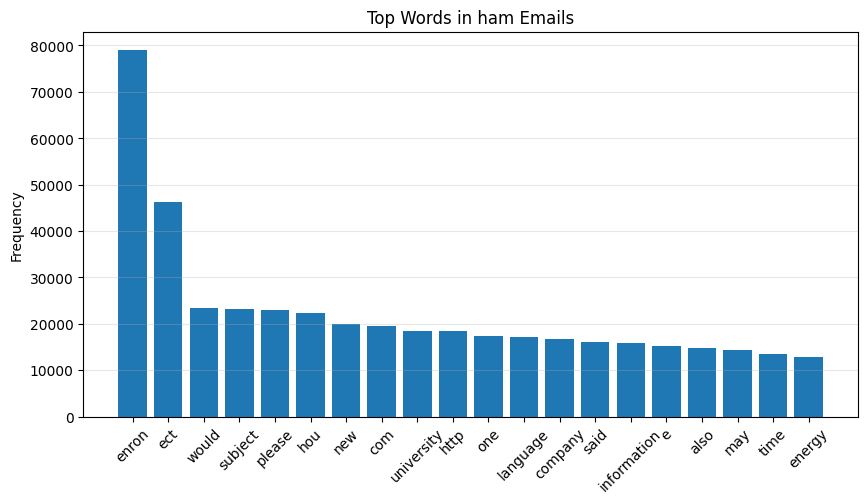

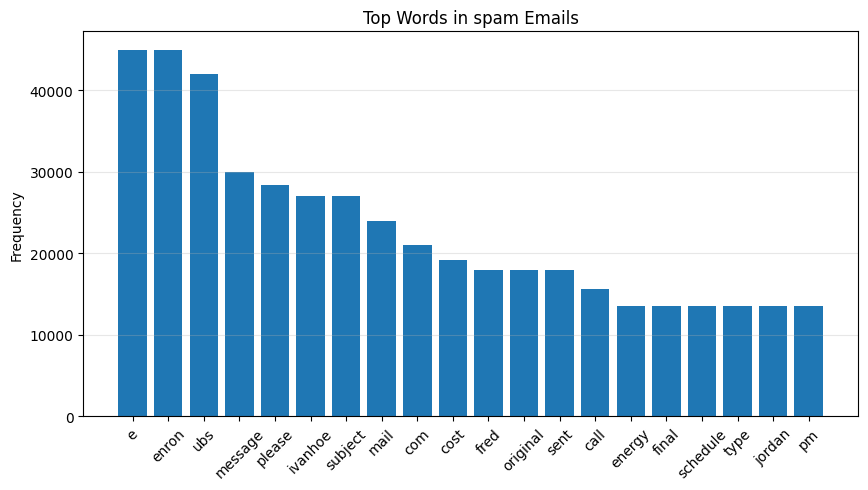

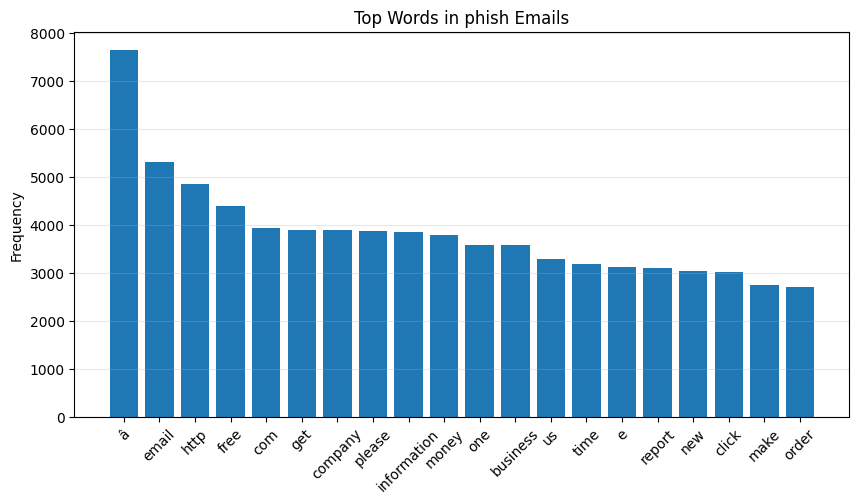

In [ ]:
stop_words = set(stopwords.words("english"))

def get_top_words(texts, n=20):
    """Return top n most common words."""
    all_words = []
    for txt in texts:
        words = word_tokenize(txt.lower())
        words = [w for w in words if w.isalpha() and w not in stop_words]
        all_words.extend(words)
    return Counter(all_words).most_common(n)


Use `get_top_words` function to plot the most common words for each category.

Initialize `top_words` and populate with top words if not already populated (process takes some time when initialized).

In [103]:
categories = summary_df["Email Type"].unique().tolist()
top_words = dict()

if Path("./top_words.json").exists():
    with open("top_words.json", 'r') as file:
        top_words = json.load(file)

if top_words.keys().isdisjoint(categories):
    for category in categories:
        words = get_top_words(summary_df[summary_df["Email Type"] == category]["Email Text"])
        top_words[category] = words

    with open("top_words.json", 'w') as file:
        json.dump(top_words, file, indent=4)

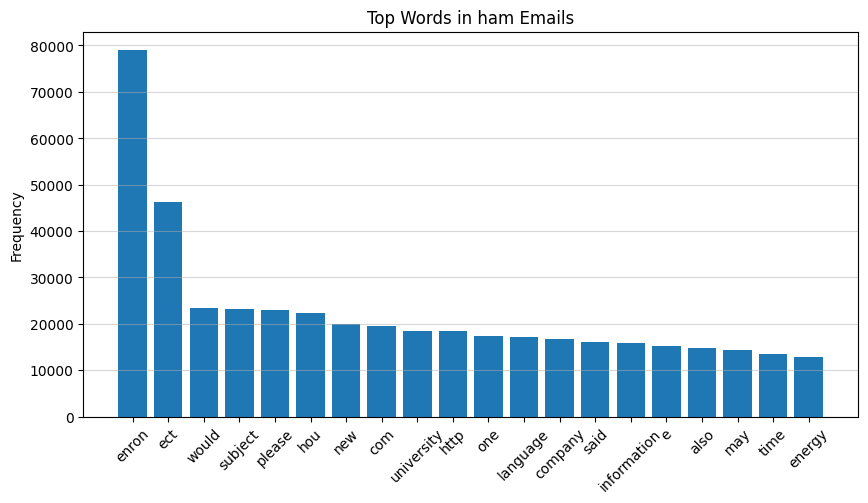

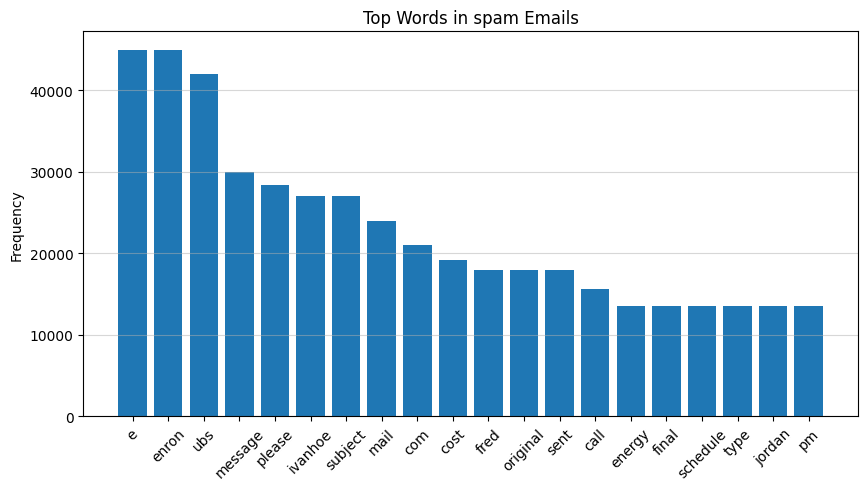

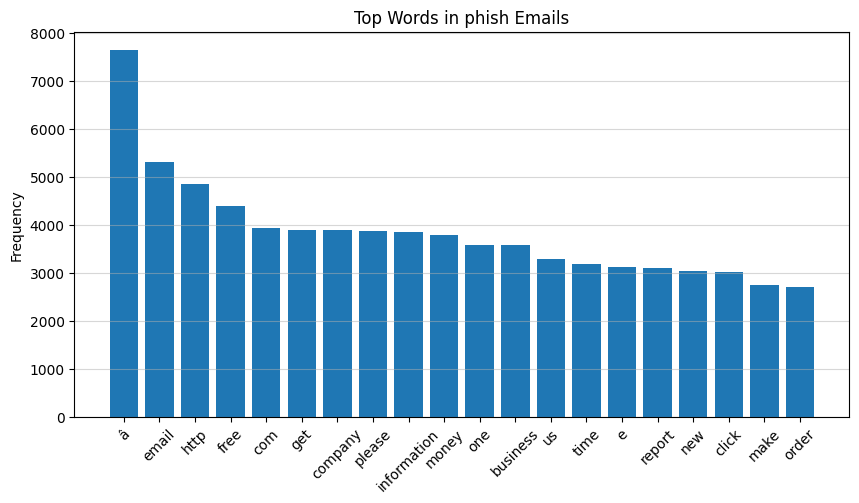

In [104]:
for category in categories:
    words, counts = zip(*top_words[category])

    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.title(f"Top Words in {category} Emails")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.5)
    plt.show()